<a href="https://colab.research.google.com/github/JPUG26/proyecto_Kaggle_Modelos_I/blob/main/04%20-%20modelo%20con%20preprocesado%20de%20agrupaci%C3%B3n%2C%20mapeo%20ordinal%20y%20casteo%20a%20category%20y%20LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 04 - modelo con preprocesado de y LGBM


In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


## Descargar archivo kaggle.json

Crear un archivo `kaggle.json` con su token de autenticación, subirlo a este espacio de trabajo del cuaderno y ejecutar la siguiente celda.

In [3]:
# Importar librería os (Operating System) de Python para modificar variables de entorno o gestionar archivos
import os

# Le indica a Kaggle dónde debe buscar el archivo de autenticación
os.environ['KAGGLE_CONFIG_DIR'] = '.'

# Comando de terminal linux para que solo el propietario pueda leer y escribir
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 808MB/s]


## Descomprimir e inspeccionar datos

In [4]:
!unzip udea*.zip > /dev/null

In [5]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


## Cargar datos de `train.csv` con pandas



In [6]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)


shape of loaded dataframe (692500, 21)


In [7]:
z.head()

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


## Eliminar filas con muchos valores nulos

In [8]:
import numpy as np
# (Asumiendo que 'z' y 'pd' ya están definidos y cargados)

cols = [
    "E_VALORMATRICULAUNIVERSIDAD","E_HORASSEMANATRABAJA","F_ESTRATOVIVIENDA",
    "F_TIENEINTERNET","F_EDUCACIONPADRE","F_TIENELAVADORA","F_TIENEAUTOMOVIL","E_PAGOMATRICULAPROPIO",
    "F_TIENECOMPUTADOR","F_EDUCACIONMADRE"
]

# 1. LIMPIEZA (Esta parte se mantiene igual)
# Reemplazar indicadores comunes de "vacío" por NaN
z[cols] = z[cols].replace({'': np.nan, 'NA': np.nan, 'N/A': np.nan, '-': np.nan})
# Limpiar celdas que solo tengan espacios
z[cols] = z[cols].replace(r'^\s*$', np.nan, regex=True)


# --- 2. NUEVA LÓGICA DE FILTRADO CONDICIONAL ---

# --- Define tus columnas y el umbral ---
col_obligatoria = "E_VALORMATRICULAUNIVERSIDAD"

# Obtenemos la lista de las otras 9 columnas "opcionales"
cols_opcionales = [col for col in cols if col != col_obligatoria]

# --- PARÁMETRO CLAVE QUE PUEDES AJUSTAR ---
# Este es el "número de nulos" (o más bien, de NO-NULOS) que pediste.
# Define cuántos valores NO NULOS deben existir en las 9 columnas opcionales
# para "salvar" una fila si la columna obligatoria (E_VALORMATRICULAUNIVERSIDAD) ES nula.

# Ejemplo: Si pones 1, significa: "Si la matrícula es nula,
#           conserva la fila si al menos 5 de las otras 9 columnas tiene un valor".
#           (Esto es similar a tu 'thresh' original de n-9)
min_non_na_opcionales = 5


# --- Construcción de las condiciones de filtrado ---

# Condición 1: Conservar si la columna obligatoria NO es nula
condicion_1 = z[col_obligatoria].notnull()

# Condición 2: Conservar si la columna obligatoria SÍ es nula,
# PERO las columnas opcionales cumplen el umbral mínimo de valores no nulos.
condicion_2 = (z[col_obligatoria].isnull()) & \
              (z[cols_opcionales].notnull().sum(axis=1) >= min_non_na_opcionales)

# 3. APLICAR EL FILTRO
# Conservamos las filas que cumplen la Condición 1 O la Condición 2
z = z[condicion_1 | condicion_2].reset_index(drop=True)

# 4. VER EL RESULTADO
print(z.shape)

(690792, 21)


# **PREPROCESADO DE DATOS**

## Creación de nueva columna en el Dataframe que agrupa en áreas de conocimiento los diferentes programas de la columna E_PRGM_ACADEMICO

In [9]:
import pandas as pd
import unicodedata
import re

# --- Definición de Funciones de Limpieza y Mapeo ---

def corregir_codificacion_consorcio(texto):
    """
    Corrige errores comunes de codificación (Mojibake) donde
    UTF-8 se malinterpretó como latin-1 o windows-1252.
    Ej: 'ADMINISTRACIÃ“N' -> 'ADMINISTRACIÓN'
    """
    if not isinstance(texto, str):
        return texto
    try:
        # Intenta decodificar de latin-1 y recodificar a UTF-8
        return texto.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        # Si falla, devuelve el texto original
        return texto

def normalizar_texto(texto):
    """
    Limpia un string:
    1. Corrige la codificación (ej: Ã“ -> Ó)
    2. Convierte a mayúsculas.
    3. Elimina acentos.
    """
    if not isinstance(texto, str):
        return ""

    # Paso 1: Corregir codificación (Mojibake)
    texto = corregir_codificacion_consorcio(texto)

    # Paso 2: Convertir a mayúsculas
    texto = texto.upper()

    # Paso 3: Eliminar acentos (Normalización NFD)
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )

    return texto.strip()

# --- Diccionario de Palabras Clave y Áreas (Priorizado) ---
MAPEO_AREAS = {
    # --- 1. Educación (Máxima Prioridad) ---
    "LICENCIATURA": "Educación (Licenciaturas)",
    "PEDAGOGIA": "Educación (Licenciaturas)",
    "ETNOEDUCACION": "Educación (Licenciaturas)",

    # --- 2. Ciencias de la Salud ---
    "ENFERMERIA": "Ciencias de la Salud",
    "MEDICINA": "Ciencias de la Salud",
    "ODONTOLOGIA": "Ciencias de la Salud",
    "PSICOLOGIA": "Ciencias de la Salud",
    "SALUD": "Ciencias de la Salud",
    "BACTERIOLOGIA": "Ciencias de la Salud",
    "FISIOTERAPIA": "Ciencias de la Salud",
    "NUTRICION": "Ciencias de la Salud",
    "INSTRUMENTACION QUIRURGICA": "Ciencias de la Salud",
    "OPTOMETRIA": "Ciencias de la Salud",
    "FONOAUDIOLOGIA": "Ciencias de la Salud",
    "TERAPIA": "Ciencias de la Salud",
    "VETERINARIA": "Ciencias de la Salud",
    "ZOOTECNIA": "Ciencias de la Salud",
    "BIOINGENIERIA": "Ciencias de la Salud",
    "BIOMEDICA": "Ciencias de la Salud",
    "GERONTOLOGIA": "Ciencias de la Salud",

    # --- 3. Ingeniería y Tecnología ---
    "INGENIERIA": "Ingeniería y Tecnología",
    "ARQUITECTURA": "Ingeniería y Tecnología",
    "SISTEMAS": "Ingeniería y Tecnología",
    "SOFTWARE": "Ingeniería y Tecnología",
    "COMPUTACION": "Ingeniería y Tecnología",
    "TELECOMUNICACIONES": "Ingeniería y Tecnología",
    "MECATRONICA": "Ingeniería y Tecnología",
    "ELECTRONICA": "Ingeniería y Tecnología",
    "MECANICA": "Ingeniería y Tecnología",
    "CIVIL": "Ingeniería y Tecnología",
    "TELEMATICA": "Ingeniería y Tecnología",
    "MULTIMEDIA": "Ingeniería y Tecnología",
    "URBANISMO": "Ingeniería y Tecnología",
    "CONSTRUCCION": "Ingeniería y Tecnología",
    "AERONAUTICA": "Ingeniería y Tecnología",
    "NANOTECNOLOGIA": "Ingeniería y Tecnología",
    "AUTOMATIZACION": "Ingeniería y Tecnología",

    # --- 4. Ciencias Económicas y Administrativas ---
    "ADMINISTRACION": "Ciencias Económicas y Administrativas",
    "ECONOMIA": "Ciencias Económicas y Administrativas",
    "CONTADURIA": "Ciencias Económicas y Administrativas",
    "FINANZAS": "Ciencias Económicas y Administrativas",
    "FINANCIERA": "Ciencias Económicas y Administrativas",
    "MERCADEO": "Ciencias Económicas y Administrativas",
    "PUBLICIDAD": "Ciencias Económicas y Administrativas",
    "NEGOCIOS": "Ciencias Económicas y Administrativas",
    "COMERCIO": "Ciencias Económicas y Administrativas",
    "HOTELERIA": "Ciencias Económicas y Administrativas",
    "TURISMO": "Ciencias Económicas y Administrativas",
    "LOGISTICA": "Ciencias Económicas y Administrativas",
    "BANCARIA": "Ciencias Económicas y Administrativas",
    "INDUSTRIAL": "Ciencias Económicas y Administrativas",

    # --- 5. Ciencias Sociales y Humanas ---
    "DERECHO": "Ciencias Sociales y Humanas",
    "JURISPRUDENCIA": "Ciencias Sociales y Humanas",
    "CIENCIA POLITICA": "Ciencias Sociales y Humanas",
    "TRABAJO SOCIAL": "Ciencias Sociales y Humanas",
    "SOCIOLOGIA": "Ciencias Sociales y Humanas",
    "ANTROPOLOGIA": "Ciencias Sociales y Humanas",
    "HISTORIA": "Ciencias Sociales y Humanas",
    "FILOSOFIA": "Ciencias Sociales y Humanas",
    "RELACIONES INTERNACIONALES": "Ciencias Sociales y Humanas",
    "GEOGRAFIA": "Ciencias Sociales y Humanas",
    "HUMANIDADES": "Ciencias Sociales y Humanas",
    "SOCIALES": "Ciencias Sociales y Humanas",
    "POLITICA": "Ciencias Sociales y Humanas",
    "GOBIERNO": "Ciencias Sociales y Humanas",
    "CRIMINALISTICA": "Ciencias Sociales y Humanas",
    "ARCHIVISTICA": "Ciencias Sociales y Humanas",
    "BIBLIOTECOLOGIA": "Ciencias Sociales y Humanas",
    "LENGUAS": "Ciencias Sociales y Humanas",
    "FILOLOGIA": "Ciencias Sociales y Humanas",
    "LETRAS": "Ciencias Sociales y Humanas",
    "LITERATURA": "Ciencias Sociales y Humanas",
    "LINGUISTICA": "Ciencias Sociales y Humanas",

    # --- 6. Artes, Diseño y Comunicación ---
    "DISEÑO": "Artes, Diseño y Comunicación",
    "COMUNICACION": "Artes, Diseño y Comunicación",
    "PERIODISMO": "Artes, Diseño y Comunicación",
    "ARTE": "Artes, Diseño y Comunicación",
    "ARTES": "Artes, Diseño y Comunicación",
    "MUSICA": "Artes, Diseño y Comunicación",
    "CINE": "Artes, Diseño y Comunicación",
    "AUDIOVISUAL": "Artes, Diseño y Comunicación",
    "FOTOGRAFIA": "Artes, Diseño y Comunicación",
    "DANZA": "Artes, Diseño y Comunicación",
    "TEATRO": "Artes, Diseño y Comunicación",
    "GASTRONOMIA": "Artes, Diseño y Comunicación",
    "CULINARIA": "Artes, Diseño y Comunicación",
    "MODAS": "Artes, Diseño y Comunicación",

    # --- 7. Ciencias Básicas y Naturales ---
    "BIOLOGIA": "Ciencias Básicas y Naturales",
    "QUIMICA": "Ciencias Básicas y Naturales",
    "FISICA": "Ciencias Básicas y Naturales",
    "MATEMATICAS": "Ciencias Básicas y Naturales",
    "ESTADISTICA": "Ciencias Básicas y Naturales",
    "GEOLOGIA": "Ciencias Básicas y Naturales",
    "ECOLOGIA": "Ciencias Básicas y Naturales",
    "ASTRONOMIA": "Ciencias Básicas y Naturales",
    "MICROBIOLOGIA": "Ciencias Básicas y Naturales",
    "GEOCIENCIAS": "Ciencias Básicas y Naturales",
    "BIOTECNOLOGIA": "Ciencias Básicas y Naturales",
    "BIOQUIMICA": "Ciencias Básicas y Naturales",

    # --- 8. Ciencias Agropecuarias y Ambientales ---
    "AGRONOMIA": "Ciencias Agropecuarias y Ambientales",
    "AGROPECUARIA": "Ciencias Agropecuarias y Ambientales",
    "AGROINDUSTRIAL": "Ciencias Agropecuarias y Ambientales",
    "AGRONEGOCIOS": "Ciencias Agropecuarias y Ambientales",
    "PECUARIA": "Ciencias Agropecuarias y Ambientales",
    "ACUICULTURA": "Ciencias Agropecuarias y Ambientales",
    "FORESTAL": "Ciencias Agropecuarias y Ambientales",
    "AGRICOLA": "Ciencias Agropecuarias y Ambientales",
    "AMBIENTAL": "Ciencias Agropecuarias y Ambientales",

    # --- 9. Otras Áreas (Menor Prioridad) ---
    "MILITARES": "Otras Áreas",
    "TEOLOGIA": "Otras Áreas",
    "NAVALES": "Otras Áreas",
    "NAUTICAS": "Otras Áreas",
    "DEPORTE": "Otras Áreas",
    "RECREACION": "Otras Áreas",
}

def asignar_area(programa):
    """
    Busca palabras clave del diccionario MAPEO_AREAS en el nombre
    del programa (ya normalizado) y devuelve el área correspondiente.
    """
    programa_norm = normalizar_texto(programa)

    for palabra_clave, area in MAPEO_AREAS.items():
        # Usamos ' in ' para buscar la palabra clave en cualquier parte del nombre
        if palabra_clave in programa_norm:
            return area

    # Si no encuentra ninguna coincidencia
    return "Área No Identificada"

z = pd.DataFrame(z)

# Aplica la función 'asignar_area' a cada fila de la columna 'E_PRGM_ACADEMICO'
# y guarda el resultado en la nueva columna 'F_AREA_CON_PRGM'
z['F_AREA_CON_PRGM'] = z['E_PRGM_ACADEMICO'].apply(asignar_area)


- La columna `RENDIMIENTO_GLOBAL` se generará utilizando el resto de las columnas.

  - `E_VALORMATRICULAUNIVERSIDAD`, que necesitaremos convertir a una **codificación continua**
  - `E_HORASSEMANATRABAJA`, que necesitaremos convertir a una **codificación continua**
  - `PERIODO_ACADEMICO`, que necesitaremos convertir a una **category**
  - `E_PRGM_DEPARTAMENTO`, que necesitaremos convertir a una **category**
  - `F_ESTRATOVIVIENDA`, que necesitaremos convertir a una **category**
  - `F_TIENEINTERNET`, que necesitaremos convertir a una **category**
  - `F_EDUCACIONPADRE`, que necesitaremos convertir a una **codificación continua**
  - `F_TIENELAVADORA`, que necesitaremos convertir a una **category**
  - `F_TIENEAUTOMOVIL`, que necesitaremos convertir a una **category**
  - `E_PRIVADO_LIBERTAD`, que necesitaremos convertir a una **category**
  - `E_PAGOMATRICULAPROPIO`, que necesitaremos convertir a una **category**
  - `F_TIENECOMPUTADOR`, que necesitaremos convertir a una **category**
  - `F_EDUCACIONMADRE`, que necesitaremos convertir a una **codificación continua**
  - `F_AREA_CON_PRGM`, que necesitaremos convertir a una **category**



## Limpieza Inicial



Sustitución de los valores `nan` con un símbolo preestablecido para marcarlos

In [10]:
# Sustitución de los valores `nan` con un símbolo preestablecido para marcarlos
z.E_PRGM_DEPARTAMENTO.values[z.E_PRGM_DEPARTAMENTO.isna()] = 'no info'
z.E_VALORMATRICULAUNIVERSIDAD.values[z.E_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
z.E_HORASSEMANATRABAJA.values[z.E_HORASSEMANATRABAJA.isna()] = 'no info'
z.F_ESTRATOVIVIENDA.values[z.F_ESTRATOVIVIENDA.isna()] = 'no info'
z.F_TIENEINTERNET.values[z.F_TIENEINTERNET.isna()] = 'no info'
z.F_EDUCACIONPADRE.values[z.F_EDUCACIONPADRE.isna()] = 'no info'
z.F_TIENELAVADORA.values[z.F_TIENELAVADORA.isna()] = 'no info'
z.F_TIENEAUTOMOVIL.values[z.F_TIENEAUTOMOVIL.isna()] = 'no info'
z.E_PAGOMATRICULAPROPIO.values[z.E_PAGOMATRICULAPROPIO.isna()] = 'no info'
z.F_TIENECOMPUTADOR.values[z.F_TIENECOMPUTADOR.isna()] = 'no info'
z.F_EDUCACIONMADRE.values[z.F_EDUCACIONMADRE.isna()] = 'no info'
z.F_AREA_CON_PRGM.values[z.F_AREA_CON_PRGM.isna()] = 'no info'

# Verificación de que ya no hay ningún valor NaN
sum(z.E_VALORMATRICULAUNIVERSIDAD.isna()), sum(z.E_HORASSEMANATRABAJA.isna()), sum(z.F_ESTRATOVIVIENDA.isna()), sum(z.F_TIENEINTERNET.isna()), sum(z.F_EDUCACIONPADRE.isna()), sum(z.F_TIENELAVADORA.isna()), sum(z.F_TIENEAUTOMOVIL.isna()), sum(z.E_PRIVADO_LIBERTAD.isna()), sum(z.E_PAGOMATRICULAPROPIO.isna()), sum(z.F_TIENECOMPUTADOR.isna()), sum(z.F_EDUCACIONMADRE.isna()), sum(z.F_AREA_CON_PRGM.isna())

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

### Conversión a valor continuo de `E_VALORMATRICULAUNIVERSIDAD`

Conversión `E_VALORMATRICULAUNIVERSIDAD` a un valor **continuo**, ya que el orden tiene sentido y queremos que los modelos puedan capturarlo.

In [11]:
# Diccionario de phyton que mapea las categorías de texto a un número flotante que represente el punto medio del rango
cmap = {
 'No pagó matrícula': 0,
 'Menos de 500 mil': .25,
 'Entre 500 mil y menos de 1 millón': .75,
 'Entre 1 millón y menos de 2.5 millones': 1.75,
 'Entre 2.5 millones y menos de 4 millones': 3.25,
 'Entre 4 millones y menos de 5.5 millones': 4.75,
 'Entre 5.5 millones y menos de 7 millones': 6.25,
 'Más de 7 millones': 7.75,
 'no info': -1}

# Reemplaza la columna original con el array de números numpy, que se creo luego de reemplazar cada texto por el número específico
z.E_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in z.E_VALORMATRICULAUNIVERSIDAD]]

# Realizar conteo de cuantas veces aparece cada valor numérico
z.E_VALORMATRICULAUNIVERSIDAD.value_counts()

,count
E_VALORMATRICULAUNIVERSIDAD,
1.75,204048
3.25,127430
0.25,80263
0.75,78704
4.75,69736
7.75,68014
6.25,38490
0.00,19528
-1.00,4579


### Conversión a valor continuo de `E_HORASSEMANATRABAJA`

Conversión `E_HORASSEMANATRABAJA` a un valor **continuo**, ya que el orden tiene sentido y quiere que los modelos puedan capturarlo.

In [12]:
# Diccionario de phyton que mapea las categorías de texto a un número flotante que represente el punto medio del rango
cmap = {
 '0': 0,
 'Menos de 10 horas': 5,
 'Entre 11 y 20 horas': 15.5,
 'Entre 21 y 30 horas': 25.5,
 'Más de 30 horas': 35.5,
 'no info': -1}

# Reemplaza la columna original con el array de números numpy, que se creo luego de reemplazar cada texto por el número específico
z.E_HORASSEMANATRABAJA = np.r_[[cmap[i] for i in z.E_HORASSEMANATRABAJA]]

# Realizar conteo de cuantas veces aparece cada valor numérico
z.E_HORASSEMANATRABAJA.value_counts()

,count
E_HORASSEMANATRABAJA,
35.5,249347
0.0,116549
15.5,115856
25.5,92692
5.0,87190
-1.0,29158


### Conversión a valor continuo de `F_EDUCACIONMADRE`

Conversión `F_EDUCACIONMADRE` a un valor **continuo**, ya que el orden tiene sentido y quiere que los modelos puedan capturarlo.

In [13]:
# Diccionario de phyton que mapea las categorías de texto a un número entero
cmap = {
 'Ninguno': 0,
 'Primaria incompleta': 1,
 'Primaria completa': 2,
 'Secundaria (Bachillerato) incompleta': 3,
 'Secundaria (Bachillerato) completa': 4,
 'Técnica o tecnológica incompleta': 5,
 'Técnica o tecnológica completa': 6,
 'Educación profesional incompleta': 7,
 'Educación profesional completa': 8,
 'Postgrado': 9,
 'no info': -1,
 'No sabe':-1,
 'No Aplica':-1 }

# Reemplaza la columna original con el array de números numpy, que se creo luego de reemplazar cada texto por el número específico
z.F_EDUCACIONMADRE = np.r_[[cmap[i] for i in z.F_EDUCACIONMADRE]]

# Realizar conteo de cuantas veces aparece cada valor numérico
z.F_EDUCACIONMADRE.value_counts()


,count
F_EDUCACIONMADRE,
4,141733
1,99414
6,89535
8,85319
3,81005
2,56121
9,46237
5,27531
-1,26948


### Conversión a valor continuo de `F_EDUCACIONPADRE`

Conversión `F_EDUCACIONPADRE` a un valor **continuo**, ya que el orden tiene sentido y quiere que los modelos puedan capturarlo.

In [14]:
# Diccionario de phyton que mapea las categorías de texto a un número entero
cmap = {
 'Ninguno': 0,
 'Primaria incompleta': 1,
 'Primaria completa': 2,
 'Secundaria (Bachillerato) incompleta': 3,
 'Secundaria (Bachillerato) completa': 4,
 'Técnica o tecnológica incompleta': 5,
 'Técnica o tecnológica completa': 6,
 'Educación profesional incompleta': 7,
 'Educación profesional completa': 8,
 'Postgrado': 9,
 'no info': -1,
 'No sabe':-1,
 'No Aplica':-1 }

# Reemplaza la columna original con el array de números numpy, que se creo luego de reemplazar cada texto por el número específico
z.F_EDUCACIONPADRE = np.r_[[cmap[i] for i in z.F_EDUCACIONPADRE]]

# Realizar conteo de cuantas veces aparece cada valor numérico
z.F_EDUCACIONPADRE.value_counts()


,count
F_EDUCACIONPADRE,
4,128281
1,125660
8,83104
3,71647
6,62990
2,55955
-1,47354
9,44163
7,27081


### `PERIODO_ACADEMICO` se parte en año y período

In [15]:
import pandas as pd

# Feature Engineering: Conversión y Slicing ---

# Paso a: Asegurar que la columna sea de tipo 'string'
# Esto nos permite "rebanarla" (slice) de forma segura
z.PERIODO_ACADEMICO = z.PERIODO_ACADEMICO.astype(str)

# Paso b: Extraer el Año (los primeros 4 caracteres)
z['anio'] = z.PERIODO_ACADEMICO.str[0:4]

# Paso c: Extraer el SubPeriodo (del 4to caracter en adelante)
z['periodo'] = z.PERIODO_ACADEMICO.str[4:]

# Conversión de Tipos (¡Paso Crítico!) ---
# Ahora tenemos dos nuevas columnas, pero AMBAS son strings.
# Debemos darles el tipo de dato semántico correcto para el modelo.

# El 'Año' es una tendencia numérica (2019 > 2018)
# Lo convertimos a entero (int)
z['anio'] = z['anio'].astype(int)

# El 'SubPeriodo' NO es numérico. Es Categórico.
# (El período 4 no es "más" que el 1, solo es "diferente")
# Lo convertimos a 'category' para que el modelo lo trate como tal
z['periodo']  = z['periodo'].astype('category')


# --- 4. Resultado Final ---
print("\n--- DATOS TRANSFORMADOS ---")
print(z)

print("\n--- NUEVOS TIPOS DE DATOS ---")
print(z.info())


--- DATOS TRANSFORMADOS ---
            ID PERIODO_ACADEMICO                     E_PRGM_ACADEMICO  \
0       904256             20212                           ENFERMERIA   
1       645256             20212                              DERECHO   
2       308367             20203                MERCADEO Y PUBLICIDAD   
3       470353             20195           ADMINISTRACION DE EMPRESAS   
4       989032             20212                           PSICOLOGIA   
...        ...               ...                                  ...   
690787   25096             20195                             BIOLOGIA   
690788  754213             20212                           PSICOLOGIA   
690789  504185             20183  ADMINISTRACIÓN EN SALUD OCUPACIONAL   
690790  986620             20195                           PSICOLOGIA   
690791  933374             20195                           PSICOLOGIA   

       E_PRGM_DEPARTAMENTO  E_VALORMATRICULAUNIVERSIDAD  E_HORASSEMANATRABAJA  \
0            

In [ ]:
print(z.info())

In [17]:
z_final = z_final.drop(columns=['anio'])

In [18]:
z_final

,PERIODO_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,F_AREA_CON_PRGM,periodo
0,20212,BOGOTÁ,6.25,5.0,Si,5,Si,Si,No,Si,9,medio-alto,0.322,0.208,Ciencias de la Salud,2
1,20212,ATLANTICO,3.25,0.0,No,6,Si,No,No,Si,5,bajo,0.311,0.215,Ciencias Sociales y Humanas,2
2,20203,BOGOTÁ,3.25,35.5,Si,4,Si,No,No,No,4,bajo,0.297,0.214,Ciencias Económicas y Administrativas,3
3,20195,SANTANDER,4.75,0.0,Si,-1,Si,No,No,Si,4,alto,0.485,0.172,Ciencias Económicas y Administrativas,5
4,20212,ANTIOQUIA,3.25,25.5,Si,2,Si,Si,No,Si,2,medio-bajo,0.316,0.232,Ciencias de la Salud,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690787,20195,LA GUAJIRA,0.75,15.5,Si,4,Si,No,Si,Si,3,medio-alto,0.237,0.271,Ciencias Básicas y Naturales,5
690788,20212,NORTE SANTANDER,3.25,35.5,Si,1,Si,No,No,Si,3,bajo,0.314,0.240,Ciencias de la Salud,2
690789,20183,BOGOTÁ,1.75,5.0,Si,4,Si,No,Si,Si,3,medio-bajo,0.286,0.240,Ciencias de la Salud,3
690790,20195,TOLIMA,3.25,5.0,No,2,No,No,Si,Si,2,bajo,0.132,0.426,Ciencias de la Salud,5


In [19]:
import pandas as pd

# Categorización de variables
z['PERIODO_ACADEMICO'] = z['PERIODO_ACADEMICO'].astype('category')
z['E_PRGM_DEPARTAMENTO'] = z['E_PRGM_DEPARTAMENTO'].astype('category')
z['F_TIENEINTERNET'] = z['F_TIENEINTERNET'].astype('category')
z['F_TIENELAVADORA'] = z['F_TIENELAVADORA'].astype('category')
z['F_TIENEAUTOMOVIL'] = z['F_TIENEAUTOMOVIL'].astype('category')
z['E_PAGOMATRICULAPROPIO'] = z['E_PAGOMATRICULAPROPIO'].astype('category')
z['F_TIENECOMPUTADOR'] = z['F_TIENECOMPUTADOR'].astype('category')
z['F_AREA_CON_PRGM'] = z['F_AREA_CON_PRGM'].astype('category')

# Verificar el tipo de dato de la columna
print(z['PERIODO_ACADEMICO'].dtype)
print(z['E_PRGM_DEPARTAMENTO'].dtype)
print(z['F_TIENEINTERNET'].dtype)
print(z['F_TIENELAVADORA'].dtype)
print(z['F_TIENEAUTOMOVIL'].dtype)
print(z['E_PAGOMATRICULAPROPIO'].dtype)
print(z['F_TIENECOMPUTADOR'].dtype)
print(z['F_AREA_CON_PRGM'].dtype)



category
category
category
category
category
category
category
category


## Convertir la columna objetivo (predicción) en valores discretos.

Ahora los conjuntos de datos son numéricos

In [20]:
y_col = 'RENDIMIENTO_GLOBAL'
rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
z_final[y_col] = [rmap[i] for i in z_final[y_col]]
z_final.head()

,PERIODO_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,F_AREA_CON_PRGM,periodo
0,20212,BOGOTÁ,6.25,5.0,Si,5,Si,Si,No,Si,9,2,0.322,0.208,Ciencias de la Salud,2
1,20212,ATLANTICO,3.25,0.0,No,6,Si,No,No,Si,5,0,0.311,0.215,Ciencias Sociales y Humanas,2
2,20203,BOGOTÁ,3.25,35.5,Si,4,Si,No,No,No,4,0,0.297,0.214,Ciencias Económicas y Administrativas,3
3,20195,SANTANDER,4.75,0.0,Si,-1,Si,No,No,Si,4,3,0.485,0.172,Ciencias Económicas y Administrativas,5
4,20212,ANTIOQUIA,3.25,25.5,Si,2,Si,Si,No,Si,2,1,0.316,0.232,Ciencias de la Salud,2


## Se construye `X` e `y` para entrenar un modelo

Se ordenan las columnas para asegurarnos de que siempre tengan el mismo orden.

In [22]:
# Reordena alfabéticamente las columnas del DataFrame Z_final
z_final = z_final[sorted(z_final.columns)]

# Crea array NumPy de características X, crea una lista de todas las columnas menos la variable objetivo 'RENDIMIENTO_GLOBAL'
X = z_final[[c for c in z_final.columns if c!=y_col]].values

# Selecciona la columna objetivo y la convierte en un array Numpy
y = z_final[y_col].values

# Verificar las dimensiones de los arrays NumPy
X.shape, y.shape

((690792, 15), (690792,))

## Dividir en conjunto de entrenamiento y probar

In [23]:
# Importar la herramienta train_test_split de la librería Scikit-learn para dividir datos
from sklearn.model_selection import train_test_split

In [24]:
# Para asignar el 80% de los datos al conjunto de entrenamiento y el 20% restante se usará para calificar al modelo
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.9,
                                      random_state=42, # Para reproducibilidad
                                      stratify=y)       # Asegura que 'y' esté balanceada)

# Imprime las dimensiones de los cuatro nuevos conjuntos de datos
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((621712, 15), (69080, 15), (621712,), (69080,))

## Crear un modelo con lightGBM

In [109]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Redefinir las columnas de características que se usarán para el entrenamiento
# Estas son las columnas de z_final excluyendo 'RENDIMIENTO_GLOBAL' (y_col)
feature_cols = [c for c in z_final.columns if c != y_col]

# Identificar características numéricas y categóricas para LightGBM
# Basado en conversiones anteriores y comprensión general de los datos
numerical_features = [
    'E_VALORMATRICULAUNIVERSIDAD',
    'E_HORASSEMANATRABAJA',
    'F_EDUCACIONPADRE',
    'F_EDUCACIONMADRE',
    'INDICADOR_1',
    'INDICADOR_2'
]
categorical_features = [
    'PERIODO_ACADEMICO',
    'E_PRGM_DEPARTAMENTO',
    'F_TIENEINTERNET',
    'F_TIENELAVADORA',
    'F_TIENEAUTOMOVIL',
    'E_PAGOMATRICULAPROPIO',
    'F_TIENECOMPUTADOR',
    'F_AREA_CON_PRGM',
    'periodo'
]

# Crear el DataFrame de características X_lgbm desde z_final, seleccionando solo las columnas relevantes
X_lgbm = z_final[feature_cols].copy()

# Convertir columnas categóricas al tipo de dato 'category' para LightGBM
for col in categorical_features:
    if col in X_lgbm.columns:
        X_lgbm[col] = X_lgbm[col].astype('category')

# Dividir los datos en conjuntos de entrenamiento y prueba
# Usar la variable global 'y' ya que está preparada como variable objetivo
Xtr_lgbm, Xts_lgbm, ytr_lgbm, yts_lgbm = train_test_split(
    X_lgbm, y, train_size=0.9, random_state=42, stratify=y
)

# Definir la lista de características categóricas para el método fit de LightGBM
# Esta lista debe contener los nombres de las columnas que son de tipo 'category'
categorical_features_for_lgbm = [col for col in Xtr_lgbm.columns if Xtr_lgbm[col].dtype.name == 'category']

lgbm_early = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=25,
    random_state=42,
    n_jobs=-1
)

print("Entrenando con Early Stopping...")
lgbm_early.fit(
    Xtr_lgbm, ytr_lgbm, # Usar los DataFrames recién preparados
    eval_set=[(Xts_lgbm, yts_lgbm)], # Usar los DataFrames recién preparados
    eval_metric='multi_logloss',
    callbacks=[lgbm.early_stopping(100)],
    categorical_feature=categorical_features_for_lgbm # Pasar la lista explícita de nombres de características categóricas
)

Entrenando con Early Stopping...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 621712, number of used features: 15
[LightGBM] [Info] Start training from score -1.387138
[LightGBM] [Info] Start training from score -1.391248
[LightGBM] [Info] Start training from score -1.395012
[LightGBM] [Info] Start training from score -1.371935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[681]	valid_0's multi_logloss: 1.22018


LGBMClassifier(learning_rate=0.05, n_estimators=1000, n_jobs=-1, num_leaves=25,
               random_state=42)

Obtener predicciones

In [110]:
preds_tr = lgbm_early.predict(Xtr_lgbm)
preds_ts = lgbm_early.predict(Xts_lgbm)

In [111]:
print (preds_tr[:10])
print (preds_ts[:10])

[1 3 3 2 3 3 3 3 1 1]
[0 3 3 3 2 2 0 0 1 0]


Precisión Global (Accuracy): 42.26%

--- Reporte Detallado por Clase ---
              precision    recall  f1-score   support

           0       0.44      0.55      0.49     17255
           1       0.33      0.27      0.29     17185
           2       0.32      0.25      0.28     17120
           3       0.54      0.62      0.57     17520

    accuracy                           0.42     69080
   macro avg       0.41      0.42      0.41     69080
weighted avg       0.41      0.42      0.41     69080


--- Matriz de Confusión ---


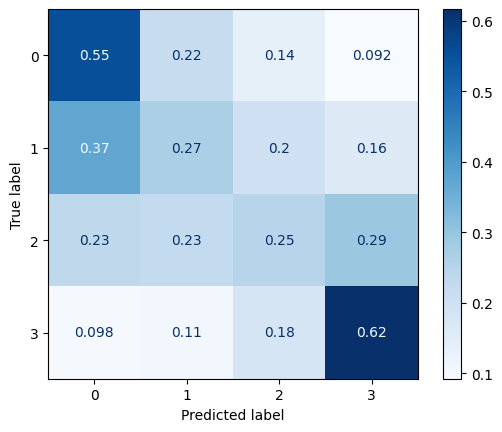

In [112]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Mide el porcentaje total de aciertos
accuracy = accuracy_score(yts_lgbm, preds_ts)
print(f"Precisión Global (Accuracy): {accuracy * 100:.2f}%")

# Cómo se comporta el modelo en cada clase individualmente
print("\n--- Reporte Detallado por Clase ---")
print(classification_report(yts_lgbm, preds_ts))

# Ayuda a ver visualmente dónde se confunde el modelo
print("\n--- Matriz de Confusión ---")
ConfusionMatrixDisplay.from_predictions(
    yts_lgbm,
    preds_ts,
    cmap='Blues',
    normalize='true'
)
plt.show()

## Se mantiene el primer modelo; ahora se aplica el mismo procedimiento a `test.csv`

Observación:
- No existe la columna `RENDIMIENTO_GLOBAL`
- Se debe conservar los ID para poder crear correctamente el archivo de envío

In [113]:
zt = pd.read_csv("test.csv")

## Eliminar filas con muchos valores nulos

In [114]:
import numpy as np

cols = [
    "E_VALORMATRICULAUNIVERSIDAD","E_HORASSEMANATRABAJA","F_ESTRATOVIVIENDA",
    "F_TIENEINTERNET","F_EDUCACIONPADRE","F_TIENELAVADORA","F_TIENEAUTOMOVIL","E_PAGOMATRICULAPROPIO",
    "F_TIENECOMPUTADOR","F_EDUCACIONMADRE"
]

# Reemplazar indicadores comunes de "vacío" por NaN
zt[cols] = zt[cols].replace({'': np.nan, 'NA': np.nan, 'N/A': np.nan, '-': np.nan})
# Limpiar celdas que solo tengan espacios
zt[cols] = zt[cols].replace(r'^\s*$', np.nan, regex=True)


# Define columnas y el umbral
col_obligatoria = "E_VALORMATRICULAUNIVERSIDAD"

# Se obtiene la lista de las otras 9 columnas "opcionales"
cols_opcionales = [col for col in cols if col != col_obligatoria]

# Define cuántos valores NO NULOS deben existir en las 9 columnas opcionales
# para "salvar" una fila si la columna obligatoria (E_VALORMATRICULAUNIVERSIDAD) ES nula.

# Ejemplo: Si se pone 5, significa: "Si la matrícula es nula,
#           conserva la fila si al menos 5 de las otras 9 columnas tiene un valor".
#           (Esto es similar a tu 'thresh' original de n-9)
min_non_na_opcionales = 5


# Construcción de las condiciones de filtrado

# Conservar si la columna obligatoria NO es nula
condicion_1 = zt[col_obligatoria].notnull()

# Conservar si la columna obligatoria SÍ es nula,
# Las columnas opcionales cumplen el umbral mínimo de valores no nulos.
condicion_2 = (zt[col_obligatoria].isnull()) & \
              (zt[cols_opcionales].notnull().sum(axis=1) >= min_non_na_opcionales)

# Conservamos las filas que cumplen la Condición 1 o la Condición 2
zt = zt[condicion_1 | condicion_2].reset_index(drop=True)

#Resultado
print(zt.shape)

(296035, 20)


## Creación de nueva columna en el Dataframe que agrupa en áreas de conocimiento los diferentes programas de la columna E_PRGM_ACADEMICO

In [115]:
import pandas as pd
import unicodedata
import re

# --- Definición de Funciones de Limpieza y Mapeo ---

def corregir_codificacion_consorcio(texto):
    """
    Corrige errores comunes de codificación (Mojibake) donde
    UTF-8 se malinterpretó como latin-1 o windows-1252.
    Ej: 'ADMINISTRACIÃ“N' -> 'ADMINISTRACIÓN'
    """
    if not isinstance(texto, str):
        return texto
    try:
        # Intenta decodificar de latin-1 y recodificar a UTF-8
        return texto.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        # Si falla, devuelve el texto original
        return texto

def normalizar_texto(texto):
    """
    Limpia un string:
    1. Corrige la codificación (ej: Ã“ -> Ó)
    2. Convierte a mayúsculas.
    3. Elimina acentos.
    """
    if not isinstance(texto, str):
        return ""

    # Paso 1: Corregir codificación (Mojibake)
    texto = corregir_codificacion_consorcio(texto)

    # Paso 2: Convertir a mayúsculas
    texto = texto.upper()

    # Paso 3: Eliminar acentos (Normalización NFD)
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )

    return texto.strip()

# --- Diccionario de Palabras Clave y Áreas (Priorizado) ---
MAPEO_AREAS = {
    # --- 1. Educación (Máxima Prioridad) ---
    "LICENCIATURA": "Educación (Licenciaturas)",
    "PEDAGOGIA": "Educación (Licenciaturas)",
    "ETNOEDUCACION": "Educación (Licenciaturas)",

    # --- 2. Ciencias de la Salud ---
    "ENFERMERIA": "Ciencias de la Salud",
    "MEDICINA": "Ciencias de la Salud",
    "ODONTOLOGIA": "Ciencias de la Salud",
    "PSICOLOGIA": "Ciencias de la Salud",
    "SALUD": "Ciencias de la Salud",
    "BACTERIOLOGIA": "Ciencias de la Salud",
    "FISIOTERAPIA": "Ciencias de la Salud",
    "NUTRICION": "Ciencias de la Salud",
    "INSTRUMENTACION QUIRURGICA": "Ciencias de la Salud",
    "OPTOMETRIA": "Ciencias de la Salud",
    "FONOAUDIOLOGIA": "Ciencias de la Salud",
    "TERAPIA": "Ciencias de la Salud",
    "VETERINARIA": "Ciencias de la Salud",
    "ZOOTECNIA": "Ciencias de la Salud",
    "BIOINGENIERIA": "Ciencias de la Salud",
    "BIOMEDICA": "Ciencias de la Salud",
    "GERONTOLOGIA": "Ciencias de la Salud",

    # --- 3. Ingeniería y Tecnología ---
    "INGENIERIA": "Ingeniería y Tecnología",
    "ARQUITECTURA": "Ingeniería y Tecnología",
    "SISTEMAS": "Ingeniería y Tecnología",
    "SOFTWARE": "Ingeniería y Tecnología",
    "COMPUTACION": "Ingeniería y Tecnología",
    "TELECOMUNICACIONES": "Ingeniería y Tecnología",
    "MECATRONICA": "Ingeniería y Tecnología",
    "ELECTRONICA": "Ingeniería y Tecnología",
    "MECANICA": "Ingeniería y Tecnología",
    "CIVIL": "Ingeniería y Tecnología",
    "TELEMATICA": "Ingeniería y Tecnología",
    "MULTIMEDIA": "Ingeniería y Tecnología",
    "URBANISMO": "Ingeniería y Tecnología",
    "CONSTRUCCION": "Ingeniería y Tecnología",
    "AERONAUTICA": "Ingeniería y Tecnología",
    "NANOTECNOLOGIA": "Ingeniería y Tecnología",
    "AUTOMATIZACION": "Ingeniería y Tecnología",

    # --- 4. Ciencias Económicas y Administrativas ---
    "ADMINISTRACION": "Ciencias Económicas y Administrativas",
    "ECONOMIA": "Ciencias Económicas y Administrativas",
    "CONTADURIA": "Ciencias Económicas y Administrativas",
    "FINANZAS": "Ciencias Económicas y Administrativas",
    "FINANCIERA": "Ciencias Económicas y Administrativas",
    "MERCADEO": "Ciencias Económicas y Administrativas",
    "PUBLICIDAD": "Ciencias Económicas y Administrativas",
    "NEGOCIOS": "Ciencias Económicas y Administrativas",
    "COMERCIO": "Ciencias Económicas y Administrativas",
    "HOTELERIA": "Ciencias Económicas y Administrativas",
    "TURISMO": "Ciencias Económicas y Administrativas",
    "LOGISTICA": "Ciencias Económicas y Administrativas",
    "BANCARIA": "Ciencias Económicas y Administrativas",
    "INDUSTRIAL": "Ciencias Económicas y Administrativas",

    # --- 5. Ciencias Sociales y Humanas ---
    "DERECHO": "Ciencias Sociales y Humanas",
    "JURISPRUDENCIA": "Ciencias Sociales y Humanas",
    "CIENCIA POLITICA": "Ciencias Sociales y Humanas",
    "TRABAJO SOCIAL": "Ciencias Sociales y Humanas",
    "SOCIOLOGIA": "Ciencias Sociales y Humanas",
    "ANTROPOLOGIA": "Ciencias Sociales y Humanas",
    "HISTORIA": "Ciencias Sociales y Humanas",
    "FILOSOFIA": "Ciencias Sociales y Humanas",
    "RELACIONES INTERNACIONALES": "Ciencias Sociales y Humanas",
    "GEOGRAFIA": "Ciencias Sociales y Humanas",
    "HUMANIDADES": "Ciencias Sociales y Humanas",
    "SOCIALES": "Ciencias Sociales y Humanas",
    "POLITICA": "Ciencias Sociales y Humanas",
    "GOBIERNO": "Ciencias Sociales y Humanas",
    "CRIMINALISTICA": "Ciencias Sociales y Humanas",
    "ARCHIVISTICA": "Ciencias Sociales y Humanas",
    "BIBLIOTECOLOGIA": "Ciencias Sociales y Humanas",
    "LENGUAS": "Ciencias Sociales y Humanas",
    "FILOLOGIA": "Ciencias Sociales y Humanas",
    "LETRAS": "Ciencias Sociales y Humanas",
    "LITERATURA": "Ciencias Sociales y Humanas",
    "LINGUISTICA": "Ciencias Sociales y Humanas",

    # --- 6. Artes, Diseño y Comunicación ---
    "DISEÑO": "Artes, Diseño y Comunicación",
    "COMUNICACION": "Artes, Diseño y Comunicación",
    "PERIODISMO": "Artes, Diseño y Comunicación",
    "ARTE": "Artes, Diseño y Comunicación",
    "ARTES": "Artes, Diseño y Comunicación",
    "MUSICA": "Artes, Diseño y Comunicación",
    "CINE": "Artes, Diseño y Comunicación",
    "AUDIOVISUAL": "Artes, Diseño y Comunicación",
    "FOTOGRAFIA": "Artes, Diseño y Comunicación",
    "DANZA": "Artes, Diseño y Comunicación",
    "TEATRO": "Artes, Diseño y Comunicación",
    "GASTRONOMIA": "Artes, Diseño y Comunicación",
    "CULINARIA": "Artes, Diseño y Comunicación",
    "MODAS": "Artes, Diseño y Comunicación",

    # --- 7. Ciencias Básicas y Naturales ---
    "BIOLOGIA": "Ciencias Básicas y Naturales",
    "QUIMICA": "Ciencias Básicas y Naturales",
    "FISICA": "Ciencias Básicas y Naturales",
    "MATEMATICAS": "Ciencias Básicas y Naturales",
    "ESTADISTICA": "Ciencias Básicas y Naturales",
    "GEOLOGIA": "Ciencias Básicas y Naturales",
    "ECOLOGIA": "Ciencias Básicas y Naturales",
    "ASTRONOMIA": "Ciencias Básicas y Naturales",
    "MICROBIOLOGIA": "Ciencias Básicas y Naturales",
    "GEOCIENCIAS": "Ciencias Básicas y Naturales",
    "BIOTECNOLOGIA": "Ciencias Básicas y Naturales",
    "BIOQUIMICA": "Ciencias Básicas y Naturales",

    # --- 8. Ciencias Agropecuarias y Ambientales ---
    "AGRONOMIA": "Ciencias Agropecuarias y Ambientales",
    "AGROPECUARIA": "Ciencias Agropecuarias y Ambientales",
    "AGROINDUSTRIAL": "Ciencias Agropecuarias y Ambientales",
    "AGRONEGOCIOS": "Ciencias Agropecuarias y Ambientales",
    "PECUARIA": "Ciencias Agropecuarias y Ambientales",
    "ACUICULTURA": "Ciencias Agropecuarias y Ambientales",
    "FORESTAL": "Ciencias Agropecuarias y Ambientales",
    "AGRICOLA": "Ciencias Agropecuarias y Ambientales",
    "AMBIENTAL": "Ciencias Agropecuarias y Ambientales",

    # --- 9. Otras Áreas (Menor Prioridad) ---
    "MILITARES": "Otras Áreas",
    "TEOLOGIA": "Otras Áreas",
    "NAVALES": "Otras Áreas",
    "NAUTICAS": "Otras Áreas",
    "DEPORTE": "Otras Áreas",
    "RECREACION": "Otras Áreas",
}

def asignar_area(programa):
    """
    Busca palabras clave del diccionario MAPEO_AREAS en el nombre
    del programa (ya normalizado) y devuelve el área correspondiente.
    """
    programa_norm = normalizar_texto(programa)

    for palabra_clave, area in MAPEO_AREAS.items():
        # Usamos ' in ' para buscar la palabra clave en cualquier parte del nombre
        if palabra_clave in programa_norm:
            return area

    # Si no encuentra ninguna coincidencia
    return "Área No Identificada"

print("Columns in zt before creating F_AREA_CON_PRGM:", zt.columns.tolist())
# Aplica la función 'asignar_area' a cada fila de la columna 'E_PRGM_ACADEMICO'
# y guarda el resultado en la nueva columna 'F_AREA_CON_PRGM'
zt['F_AREA_CON_PRGM'] = zt['E_PRGM_ACADEMICO'].apply(asignar_area)

Columns in zt before creating F_AREA_CON_PRGM: ['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']


In [116]:
# Mapeo Matrícula
map_matricula = {
 'No pagó matrícula': 0, 'Menos de 500 mil': .25, 'Entre 500 mil y menos de 1 millón': .75,
 'Entre 1 millón y menos de 2.5 millones': 1.75, 'Entre 2.5 millones y menos de 4 millones': 3.25,
 'Entre 4 millones y menos de 5.5 millones': 4.75, 'Entre 5.5 millones y menos de 7 millones': 6.25,
 'Más de 7 millones': 7.75, 'no info': -1
}
zt['E_VALORMATRICULAUNIVERSIDAD'] = zt['E_VALORMATRICULAUNIVERSIDAD'].map(map_matricula).fillna(-1)

# Mapeo Horas Trabajo
map_horas = {
 '0': 0, 'Menos de 10 horas': 5, 'Entre 11 y 20 horas': 15.5,
 'Entre 21 y 30 horas': 25.5, 'Más de 30 horas': 35.5, 'no info': -1
}
zt['E_HORASSEMANATRABAJA'] = zt['E_HORASSEMANATRABAJA'].map(map_horas).fillna(-1)

# Mapeo Educación (Padre y Madre)
map_educacion = {
 'Ninguno': 0, 'Primaria incompleta': 1, 'Primaria completa': 2,
 'Secundaria (Bachillerato) incompleta': 3, 'Secundaria (Bachillerato) completa': 4,
 'Técnica o tecnológica incompleta': 5, 'Técnica o tecnológica completa': 6,
 'Educación profesional incompleta': 7, 'Educación profesional completa': 8,
 'Postgrado': 9, 'no info': -1, 'No sabe':-1, 'No Aplica':-1
}
# Convertir a string primero para evitar errores de tipos mixtos, luego se mapea
zt['F_EDUCACIONPADRE'] = zt['F_EDUCACIONPADRE'].astype(str).map(map_educacion).fillna(-1).astype(int)
zt['F_EDUCACIONMADRE'] = zt['F_EDUCACIONMADRE'].astype(str).map(map_educacion).fillna(-1).astype(int)

# a. Crear Áreas (Asegúrate que la función 'asignar_area' esté definida en celdas anteriores)
zt['E_PRGM_ACADEMICO'] = zt['E_PRGM_ACADEMICO'].fillna('no info')
zt['F_AREA_CON_PRGM'] = zt['E_PRGM_ACADEMICO'].apply(asignar_area)

# b. Procesar Periodo
zt['PERIODO_ACADEMICO'] = zt['PERIODO_ACADEMICO'].astype(str)
zt['periodo'] = zt['PERIODO_ACADEMICO'].str[4:] # Extraer subperiodo

# Definimos las columnas EXACTAS que usó el modelo (sin ID, sin texto original)
feature_cols = [
    'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA',
    'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE',
    'INDICADOR_1', 'INDICADOR_2',
    'PERIODO_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
    'F_TIENEINTERNET', 'F_TIENELAVADORA',
    'F_TIENEAUTOMOVIL', 'E_PAGOMATRICULAPROPIO',
    'F_TIENECOMPUTADOR', 'F_AREA_CON_PRGM',
    'periodo'
]

# Lista de columnas que LightGBM debe tratar como categorías
categorical_features = [
    'PERIODO_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
    'F_TIENEINTERNET', 'F_TIENELAVADORA',
    'F_TIENEAUTOMOVIL', 'E_PAGOMATRICULAPROPIO',
    'F_TIENECOMPUTADOR', 'F_AREA_CON_PRGM',
    'periodo'
]

# Se crea el DataFrame final de test solo con las columnas necesarias
X_test_final = zt[feature_cols].copy()

# Se convierte a 'category' para que coincida con el entrenamiento
for col in categorical_features:
    if col in X_test_final.columns:
        # Se rellena nulos con 'no info' antes de convertir a categoría
        X_test_final[col] = X_test_final[col].fillna('no info').astype('category')

# Verificación
print("Dimensiones finales del Test:", X_test_final.shape)
print(X_test_final.info())

preds_test = lgbm_early.predict(X_test_final)

Dimensiones finales del Test: (296035, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296035 entries, 0 to 296034
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   E_VALORMATRICULAUNIVERSIDAD  296035 non-null  float64 
 1   E_HORASSEMANATRABAJA         296035 non-null  float64 
 2   F_EDUCACIONPADRE             296035 non-null  int64   
 3   F_EDUCACIONMADRE             296035 non-null  int64   
 4   INDICADOR_1                  296035 non-null  float64 
 5   INDICADOR_2                  296035 non-null  float64 
 6   PERIODO_ACADEMICO            296035 non-null  category
 7   E_PRGM_DEPARTAMENTO          296035 non-null  category
 8   F_TIENEINTERNET              296035 non-null  category
 9   F_TIENELAVADORA              296035 non-null  category
 10  F_TIENEAUTOMOVIL             296035 non-null  category
 11  E_PAGOMATRICULAPROPIO        296035 non-null  category
 12  F

## Preparar la entrega

Primero, convierte las predicciones de nuevo a sus valores textuales.

In [117]:
# Mapeo inverso
rmap = {'alto': 3, 'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2}
rmapi = {v: k for k, v in rmap.items()}
text_preds = [rmapi[i] for i in preds_test]


In [119]:
# crear csv
zt_ids = zt['ID'].values
submission = pd.DataFrame({
    'ID': zt_ids,
    'RENDIMIENTO_GLOBAL': text_preds
})

In [120]:
# Guardar archivo listo para entregar
submission.to_csv("submission.csv", index=False)
print(submission.head())

       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545               bajo
2  499179               bajo
3  782980               bajo
4  785185               bajo


In [121]:
!head my_submission.csv

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,bajo
499179,bajo
782980,bajo
785185,bajo
58495,bajo
705444,bajo
557548,bajo
519909,bajo


In [122]:
submission.shape

(296035, 2)

## Send your submission to Kaggle

You must **join the competition** first

In [ ]:
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f my_submission.csv -m "Entrega actualizada Pablo Uribe"